# Transtornos Mentais Relacionados ao Trabalho no Município de Campinas - SP
## MO810 - Feminismo de dados

# Importações e leitura das bases de dados e outros arquivos auxiliares

In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml
from collections import defaultdict


df = pd.read_excel("data/Campinas_all.xlsx")

def age_in_years(age):
    in_years = -1
    if str(age)[0] == '4':
        in_years = age - 4000 
    return in_years

def get_cid_descriptions(counts):
    cid_10 = pd.read_csv('data/CID-10-SUBCATEGORIAS.csv', encoding='latin-1', on_bad_lines='skip', sep=';')

    dict_cid = {}
    for code in counts.index:
        code_str = code.strip()
        if code_str == "Vazio" or code_str == "Outros":
            dict_cid[code] = code_str
        else:
            if len(code_str) == 3:
                code_str = code_str + '0'
            desc = cid_10[cid_10.SUBCAT == code_str]['DESCRICAO'].iloc[0]

            dict_cid[code] = code_str[:3] + "." + code_str[3:] + " (" + desc + ")"
    return dict_cid

def preprocess_cid(cid):
    cid = cid.strip()
    if len(cid) > 0 and len(cid) != 4:
        cid = cid + '0'
    return cid
    
df['AGE_IN_YEARS'] = df.NU_IDADE_N.apply(age_in_years)
df['DIAG_ESP'] = df.DIAG_ESP.apply(preprocess_cid)

# Read the YAML file
with open("data/sinan_fields.yaml", "r", encoding="utf-8") as f:
    sinan_fields = yaml.safe_load(f)

with open("data/ignored_keys.yaml", "r", encoding="utf-8") as f:
    ignored_keys = yaml.safe_load(f)

# Métodos auxiliares

In [2]:
def wrap_label(label, max_len=50):
    """Insert a newline at the closest space before max_len."""
    if len(label) <= max_len:
        return label
    
    # Find last space before limit
    space_pos = label.rfind(" ", 0, max_len)
    
    # If no space found, just force-break
    if space_pos == -1:
        return label[:max_len] + "\n" + label[max_len:]
    
    return label[:space_pos] + "\n" + wrap_label(label[space_pos+1:])

def plot2x2heatmap(data, x_labels, y_labels, title, xlabel, ylabel, shrink=0.75):
    
    plt.figure(figsize=(6, 6))
    
    ax = sns.heatmap(
        data,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=x_labels,
        yticklabels=y_labels,
        square=True,    # ensures perfect squares
        cbar_kws={
            "shrink": shrink,   # make colorbar same height as the plot
            # "pad": 0.02,     # reduce spacing between heatmap and colorbar
            # "aspect": 20     # colorbar thickness (optional)
        }
    )
    plt.title(title, fontsize=16, pad=16,  weight="bold")
    ax.set_xlabel(xlabel, fontsize=14, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)
    
    plt.tight_layout()
    plt.show()

# Média de variáveis vazias/desconhecidas por recorte interseccional

In [3]:
def count_empty(row, ignored_keys):
    empty_count = 0
    for value in row:
        # Check for null values
        if pd.isna(value):
            empty_count += 1
            continue

        # Case 2: empty or whitespace-only
        if str(value).strip() == "":
            empty_count += 1

    for col, ignored_list in ignored_keys.items():
        if str(row[col]) in ignored_list:
            empty_count += 1
    return empty_count


## Raça cor + sexo

In [4]:
racas_alvo = ['1', '2', '3', '4', '5']
racas_negro = ['2', '4'] # pretos + pardos

# Elimina raça ignorada ou vazia
raca_conhecida = df[df.CS_RACA.isin(racas_alvo)]

# Filta por intersecção raça + gênero
homens_brancos = raca_conhecida[(raca_conhecida.CS_RACA == '1') & (raca_conhecida.CS_SEXO == 'M')]
mulheres_brancas = raca_conhecida[(raca_conhecida.CS_RACA == '1') & (raca_conhecida.CS_SEXO == 'F')]
homens_negros = raca_conhecida[(raca_conhecida.CS_RACA.isin(racas_negro)) & (raca_conhecida.CS_SEXO == 'M')]
mulheres_negras = raca_conhecida[(raca_conhecida.CS_RACA.isin(racas_negro)) & (raca_conhecida.CS_SEXO == 'F')]

print(f"Total: {len(df)}\nRaça conhecida: {len(raca_conhecida)}\n")
print(f"Homens Brancos: {len(homens_brancos)}\nMulheres Brancas: {len(mulheres_brancas)}\n")
print(f"Homens Negros: {len(homens_negros)}\nMulheres Negras: {len(homens_negros)}\n")

Total: 277
Raça conhecida: 189

Homens Brancos: 45
Mulheres Brancas: 77

Homens Negros: 22
Mulheres Negras: 22



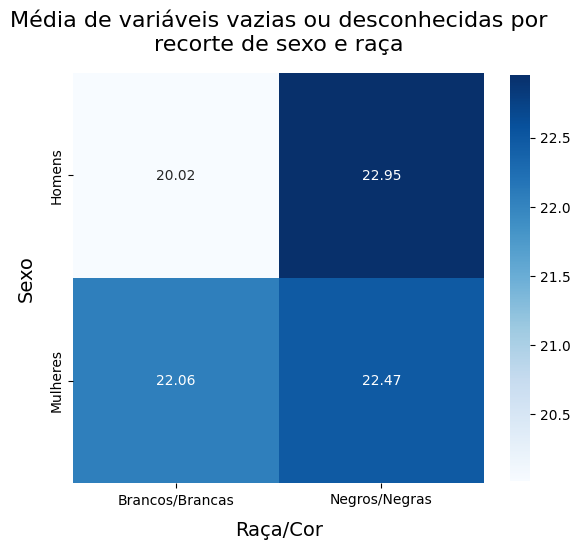

In [5]:

vazios = defaultdict(int)

vazios['Homens Brancos'] = homens_brancos.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(homens_brancos)
vazios['Mulheres Brancas'] = mulheres_brancas.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(mulheres_brancas)
vazios['Homens Negros'] = homens_negros.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(homens_negros)
vazios['Mulheres Negras'] = mulheres_negras.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(mulheres_negras)
vazios = {k: round(v, 2) for k, v in vazios.items()}


order = [
    ['Homens Brancos', 'Homens Negros'],
    ['Mulheres Brancas', 'Mulheres Negras']
]


data = np.array([[vazios[key] for key in row] for row in order])
plot2x2heatmap(data, ["Brancos/Brancas", "Negros/Negras"], ["Homens", "Mulheres"],
              "Média de variáveis vazias ou desconhecidas por\nrecorte de sexo e raça",
              "Raça/Cor", "Sexo")

## Apenas sexo

Total: 277
Homens: 120
Mulheres: 157

Homens: 21.97
Mulheres: 22.87


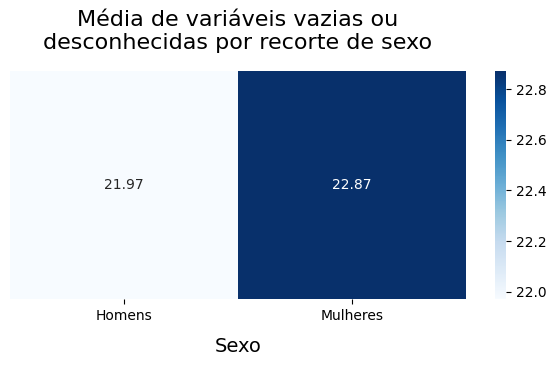

In [6]:
# Filta por intersecção raça + gênero
homens = df[df.CS_SEXO == 'M']
mulheres = df[df.CS_SEXO == 'F']

print(f"Total: {len(df)}\nHomens: {len(homens)}\nMulheres: {len(mulheres)}\n")

vazios = defaultdict(int)

vazios['Homens'] = homens.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(homens)
vazios['Mulheres'] = mulheres.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(mulheres)
vazios = {k: round(v, 2) for k, v in vazios.items()}

for k, v in vazios.items():
    print(f"{k}: {v:.2f}")

order = [
    ['Homens', 'Mulheres'],
]


data = np.array([[vazios[key] for key in row] for row in order])
plot2x2heatmap(data, ["Homens", "Mulheres"], [],
              "Média de variáveis vazias ou\ndesconhecidas por recorte de sexo",
              "Sexo", None, shrink=0.4)

## Apenas raça

Total: 277
Brancos: 122
Negros: 65

Brancos: 21.31
Negros: 22.63


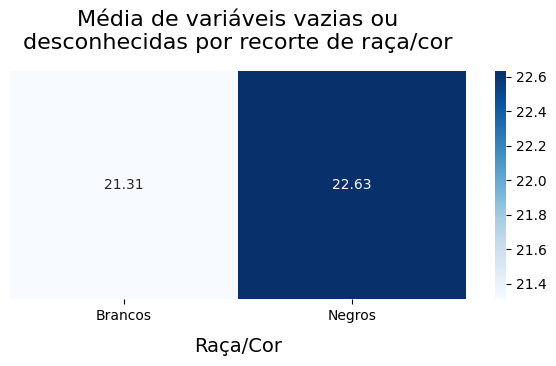

In [7]:
# Filta por intersecção raça + gênero
brancos = df[(df.CS_RACA == '1')]
negros = df[(df.CS_RACA.isin(racas_negro))]

print(f"Total: {len(df)}\nBrancos: {len(brancos)}\nNegros: {len(negros)}\n")

vazios = defaultdict(int)

vazios['Brancos'] = brancos.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(brancos)
vazios['Negros'] = negros.apply(lambda row: count_empty(row, ignored_keys), axis=1).sum() / len(negros)
vazios = {k: round(v, 2) for k, v in vazios.items()}

for k, v in vazios.items():
    print(f"{k}: {v:.2f}")

order = [
    ['Brancos', 'Negros'],
]

data = np.array([[vazios[key] for key in row] for row in order])
plot2x2heatmap(data, ["Brancos", "Negros"], [],
              "Média de variáveis vazias ou\ndesconhecidas por recorte de raça/cor",
              "Raça/Cor", None, shrink=0.4)

# Distribuições de variáveis

## Idade

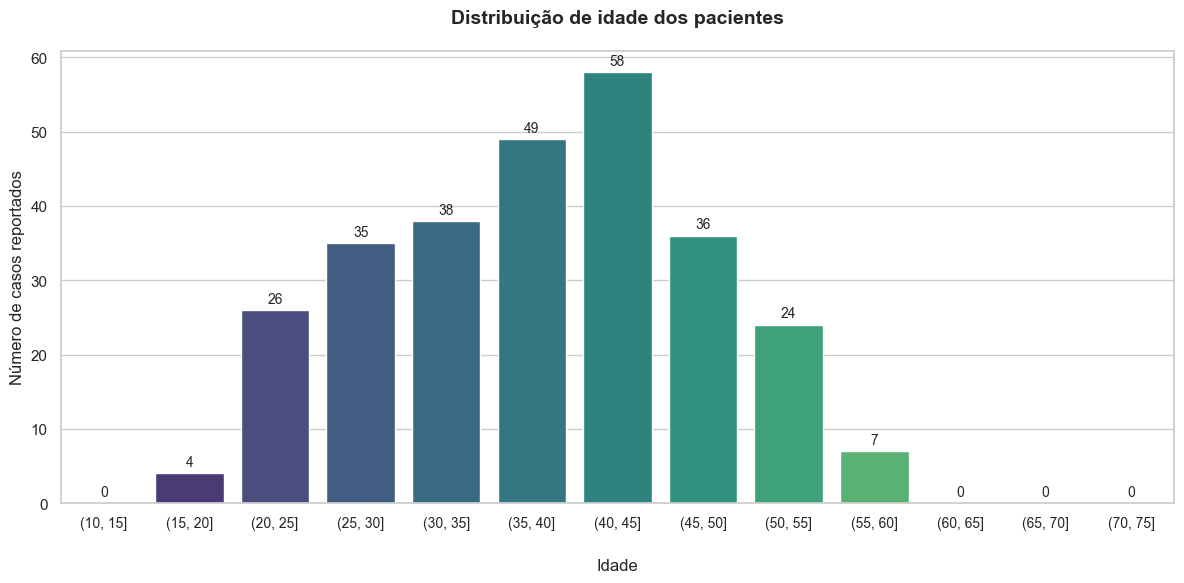

In [8]:
def plot_age(df, debug=False):
    sns.set(style="whitegrid")
    size = (12, 6)
    ranges = [5*i for i in range(2, 16)]
    counts = df.groupby(pd.cut(df.AGE_IN_YEARS, ranges), observed=False)['AGE_IN_YEARS'].count()

    plt.figure(figsize=size)
    ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='viridis', order=counts.index, legend=False)

    # Adicionar rótulos nas barras
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values) * 0.01, str(v), ha="center", va="bottom", fontsize=10)

    plt.title("Distribuição de idade dos pacientes", fontsize=14, weight="bold", pad=20)
    plt.xlabel("Idade", fontsize=12, labelpad=20)
    plt.ylabel("Número de casos reportados", fontsize=12)

    plt.xticks(rotation=0, ha="center", fontsize=10)
    plt.tight_layout()
    plt.show()

    
plot_age(df, sinan_fields);

## Área de atuação (CNAE)

In [9]:
# Lê as tabelas do CNAE e de conversão
cnae = pd.read_excel("data/CNAE20_EstruturaDetalhada.xls", header=2)
cnae["Divisão"] = cnae["Divisão"].astype(str)
cnae_correspond = pd.read_excel("data/CNAE20_Correspondencias.xls", sheet_name='CNAE 1.0 x CNAE 2')

# Converte o código para o CNAE 2.0 se for o código do CNAE 1.0. Mantém o mesmo caso contrário
def convert_to_cnae20(cnae_cod, cnae, cnae_correspondence):
    cnae_cod = cnae_cod.strip()

    # Se o código estiver vazio, retorna vazio
    if len(cnae_cod) == 0:
        return ""

    # Procura o código na tabela do CNAE 2.0
    cnae_data = cnae[cnae.CLASSE2 == cnae_cod]

    # Se não encontrou, procura na tabela de conversão
    if len(cnae_data) == 0:
        converted = cnae_correspondence[cnae_correspond.COD1 == cnae_cod]['COD2'].iloc[0]
        cnae_cod = converted

    return cnae_cod

# Obtém o campo "Denominação" na tabela do CNAE 2.0 correspondente ao código
def get_cnae2_name(cnae_cod, cnae):
    if len(cnae_cod.strip()) == 0:
        return pd.NA

    code = f"{cnae_cod[:2]:02}"
    cnae_desc = cnae[cnae["Divisão"] == code]["Denominação"].iloc[0].title()

    return cnae_desc

# Limpa o código da classe removendo traço e ponto
def clean_up_class(cl):
    if pd.isna(cl):
        return pd.NA
    return cl.replace(".", "").replace("-", "")


# Limpa os códigos das classes para facilitar o match com a planilha do SINAN
cnae['CLASSE2'] = cnae['Classe'].apply(clean_up_class)
cnae_correspond['COD1'] = cnae_correspond['código1'].apply(clean_up_class)
cnae_correspond['COD2'] = cnae_correspond['código2'].apply(clean_up_class)

# Converte todos os códigos para o CNAE 2.0
df['CNAE_20_conv'] = df['CNAE'].apply(lambda x: convert_to_cnae20(x, cnae, cnae_correspond))

# Obtém as descrições correspondentes
df['CNAE_DENOM'] = df['CNAE_20_conv'].apply(lambda x: get_cnae2_name(x, cnae))



FileNotFoundError: [Errno 2] No such file or directory: 'imgs/graph_cnae_simplificado_low_res.png'

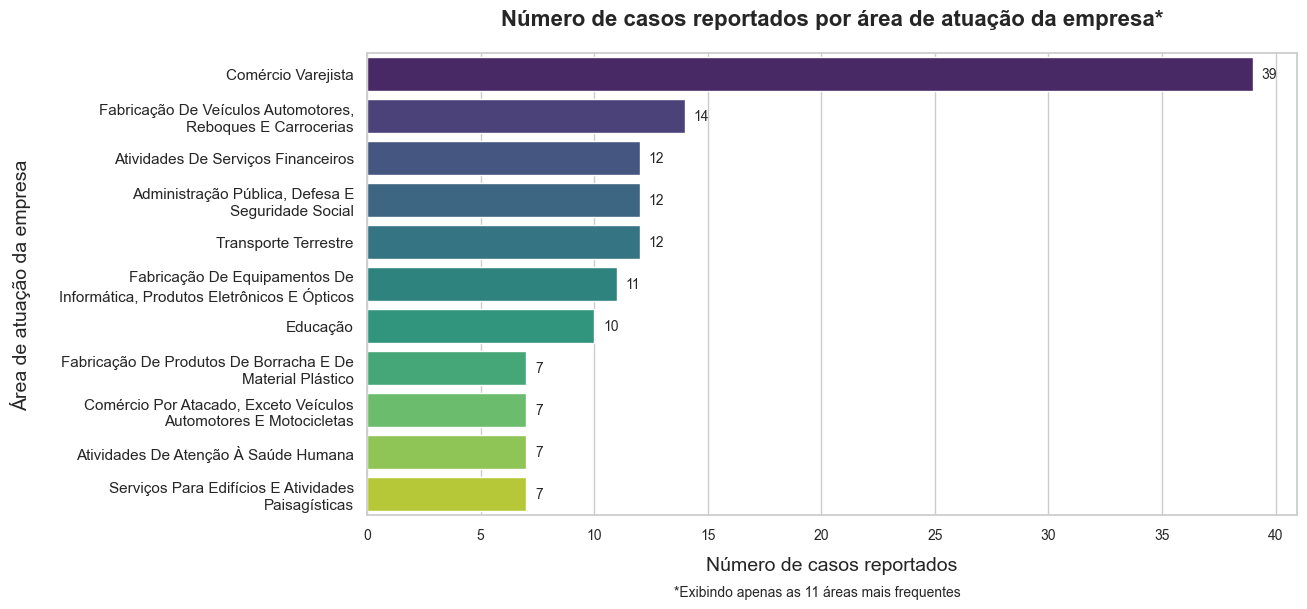

In [10]:
def plot_bar_graph_cnae(df, fields_dict, top_n=10):
    sns.set(style="whitegrid")
    size = (12, 6)

    # Contagem de valores
    counts = df['CNAE_DENOM'].value_counts().sort_values(ascending=False).head(top_n)

    plt.figure(figsize=size)
    # ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='viridis', order=counts.index, legend=False)

    wrapped_labels = [wrap_label(str(lbl), max_len=40) for lbl in counts.index]
    ax = sns.barplot(y=counts.index, x=counts.values, hue=counts.index, palette='viridis', legend=False, orient="h")

    labelpad = 10

    ytitle = "Área de atuação da empresa"
    xtitle = "Número de casos reportados"

    # Adicionar rótulos nas barras
    for i, v in enumerate(counts.values):
        ax.text(v + max(counts.values) * 0.01, i, str(v), ha="left", va="center", fontsize=10)

        
    plt.title("Número de casos reportados por área de atuação da empresa*", fontsize=16, weight="bold", pad=20)
    plt.ylabel(ytitle, fontsize=14, labelpad=20)
    plt.xlabel(xtitle, fontsize=14, labelpad=labelpad)

    plt.xticks(rotation=0, ha="center", fontsize=10)
    plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

    plt.figtext(
        0.5,               # x-position (0 = left, 1 = right)
        -0.025,             # y-position BELOW the plot
        "*Exibindo apenas as 11 áreas mais frequentes",
        wrap=True,
        horizontalalignment='center',
        fontsize=10
    )

    plt.tight_layout()
    plt.show()
    return counts

plot_bar_graph_cnae(df, sinan_fields, top_n=11);

## Diagnóstico Específico

In [ ]:
def plot_bar_graph_diag(df, fields_dict, top_n=10):
    sns.set(style="whitegrid")
    size = (14, 8)

    # Contagem de valores
    counts = df['DIAG_ESP'].value_counts().sort_values(ascending=False).head(top_n)
    cod_cid = get_cid_descriptions(counts)
    counts.index = counts.index.map(lambda x: cod_cid[x])

    plt.figure(figsize=size)

    wrapped_labels = [wrap_label(str(lbl), max_len=45) for lbl in counts.index]
    ax = sns.barplot(y=counts.index, x=counts.values, hue=counts.index, palette='viridis', legend=False, orient="h")

    labelpad = 10

    ytitle = "Diagnóstico Específico (CID-10)"
    xtitle = "Número de casos reportados"

    # Adicionar rótulos nas barras
    for i, v in enumerate(counts.values):
        ax.text(v + max(counts.values) * 0.01, i, str(v), ha="left", va="center", fontsize=10)

        
    plt.title("Número de casos reportados por diagnóstico específico*", fontsize=16, weight="bold", pad=20)
    plt.ylabel(ytitle, fontsize=14, labelpad=20)
    plt.xlabel(xtitle, fontsize=14, labelpad=labelpad)

    plt.xticks(rotation=0, ha="center", fontsize=10)
    plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

    plt.figtext(
        0.5,               # x-position (0 = left, 1 = right)
        -0.025,             # y-position BELOW the plot
        "*Exibindo apenas os 12 diagnósticos mais frequentes e excluindo-se campos vazios.",
        wrap=True,
        horizontalalignment='center',
        fontsize=10
    )

    plt.tight_layout()
    plt.show()
    return counts


# Elimina linhas com DIAG_ESP vazio
df_sem_vazio = df[df.DIAG_ESP.str.len() > 0]

plot_bar_graph_diag(df_sem_vazio, sinan_fields, top_n=12);

## Evolução do caso

In [ ]:
def plot_bar_graph_evolucao(df, fields_dict, top_n=10):
    sns.set(style="whitegrid")
    size = (14, 8)

    # Contagem de valores
    counts = df['EVOLUCAO'].value_counts().sort_values(ascending=False).head(top_n)
    # counts.index = counts.index.map(lambda x: fields_dict['EVOLUCAO']['valores'][x] if )

    value_map = fields_dict.get('EVOLUCAO', {}).get("valores")
    counts.index = counts.index.map(lambda x: value_map.get(str(x), str(x)))
    counts.index = [idx if str(idx).strip() != "" else "Vazio" for idx in counts.index]
    
    plt.figure(figsize=size)

    wrapped_labels = [wrap_label(str(lbl), max_len=40) for lbl in counts.index]
    ax = sns.barplot(y=counts.index, x=counts.values, hue=counts.index, palette='viridis', legend=False, orient="h")

    labelpad = 10

    ytitle = "Evolução do caso"
    xtitle = "Número de casos reportados"

    # Adicionar rótulos nas barras
    for i, v in enumerate(counts.values):
        ax.text(v + max(counts.values) * 0.01, i, str(v), ha="left", va="center", fontsize=10)

        
    plt.title("Evolução dos casos", fontsize=16, weight="bold", pad=20)
    plt.ylabel(ytitle, fontsize=14, labelpad=20)
    plt.xlabel(xtitle, fontsize=14, labelpad=labelpad)

    plt.xticks(rotation=0, ha="center", fontsize=10)
    plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

    plt.tight_layout()
    plt.show()
    return counts


plot_bar_graph_evolucao(df, sinan_fields);

## Completude de variáveis

### Raça/cor + sexo

In [ ]:
def check_completeness(df, column, data_dict, created2018=None):
    total = len(df)

    # Conta colunas vazias
    tmp = df[column].apply(lambda x: str(x).strip())
    empty = tmp[tmp == ''].count()

    # Conta NA ou Nan

    # Algumas colunas foram criadas em 2018, então remove dados anteriores
    if created2018 and column in created_2018:
        empty += df[df.ANO >= 2018][column].isna().sum()
    else:
        empty += df[column].isna().sum()

    # Conta valores ignorados
    if column in data_dict.keys() and 'valores' in data_dict[column].keys() and "Ignorado" in data_dict[column]['valores'].values():
        for k, v in data_dict[column]['valores'].items():
            if 'Ignorado' == v:
                ignored_count = df[column].astype(str).value_counts()
                if k in ignored_count.keys():
                    empty += ignored_count[k]
        
    return 100*(1 - empty/total)

def get_full_completeness(df, columns, data_dict, created_2018=None, full_name=False):
    completeness = {}
    for c in columns:
        comp = check_completeness(df, c, data_dict, created_2018)
        if full_name and c in data_dict.keys():
            completeness[data_dict[c]['nome']] = comp
        else:
            completeness[c] = comp
    return completeness


completeness = {}
df = pd.read_excel("data/Campinas_all.xlsx")
columns = list(df.columns)
completeness["hb"] = get_full_completeness(homens_brancos, columns, sinan_fields)
completeness["mb"] = get_full_completeness(mulheres_brancas, columns, sinan_fields)
completeness["hn"] = get_full_completeness(homens_negros, columns, sinan_fields)
completeness["mn"] = get_full_completeness(mulheres_negras, columns, sinan_fields)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import PercentFormatter

def plot_demographic_heatmap(df, col_names, data_dict, title="Heatmap", cmap="plasma", rotation=0):
    values = df.values
    rows = [wrap_label(data_dict[k]['title'], 25) for k in df.index]
    # rows = df.index
    cols = col_names

    values = values[::-1]          # reverse rows
    rows = rows[::-1]              # reverse row labels

    plt.figure(figsize=(12, 8))
    plt.imshow(values, cmap=cmap, aspect="equal", interpolation="nearest")

    # Determine threshold for switching text color
    threshold = np.mean(values)
    
    # Add value labels inside cells
    for i in range(values.shape[0]):       # rows (measurements)
        for j in range(values.shape[1]):   # columns (demographics)
            text_color = 'black'

            plt.text(j, i, f"{values[i, j]:.2f}%",
                     ha="center", va="center", color=text_color, fontsize=10)

            
    cbar = plt.colorbar(shrink=0.75)
    cbar.ax.yaxis.set_major_formatter(PercentFormatter())
    
    plt.xticks(np.arange(len(cols)), cols, rotation=rotation, ha="center")
    plt.yticks(np.arange(len(rows)), rows)

    plt.title(title, fontsize=14, weight="bold")

    ax = plt.gca()
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(rows)))
    
    ax.set_xticks(np.arange(values.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(values.shape[0] + 1) - 0.5, minor=True)
    ax.grid(False)                     # disables grid lines
    ax.tick_params(which="minor", size=0)
    plt.subplots_adjust(left=0.1, right=0.95)
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

df_completeness = pd.DataFrame(completeness)
df_completeness['row_std'] = df_completeness.std(axis=1)

# Checa as variáveis que possuem 100% de completude em todas
mask = df_completeness[completeness.keys()].eq(100.0).all(axis=1)
print(f"Variáveis com 100% de completude em todos os recortes:\n{list(df_completeness[mask].index)}")
df_completeness = df_completeness[~mask]

# Selected columns to display
columns = ['CS_GESTANT', 'CS_ESCOL_N', 'COLETIVA', 'CAT', 'AFAST_DESG', 'AFAST_TRAB']

df_completeness = df_completeness.sort_values(by='row_std', ascending=False)
df_completeness = df_completeness[df_completeness.index.isin(columns)].drop('row_std', axis=1)[::-1]

display(df_completeness)

In [ ]:
plot_demographic_heatmap(df_completeness, ['Homens\nBrancos', 'Mulheres\nBrancas', 'Homens\nNegros', 'Mulheres\nNegras'],
                        sinan_fields, title="Completude de variáveis por recorte de raça/sexo", cmap="coolwarm_r")